<a href="https://colab.research.google.com/github/pathilink/mapa_acolhimento_case/blob/main/notebook/mapa_acolhimento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='#622567'>Mapa do Acolhimento Case </font>

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data

In [2]:
df = pd.read_csv('/content/drive/MyDrive/test/mapa_do_acolhimento/full_matches.csv')
df.head()

,match_id,created_at,msr_id,msr_city,msr_state,volunteer_id,volunteer_city,volunteer_state
0,11926,2023-02-15 18:57:14.000,13227945871252,SAO PAULO,SP,27683,SAO PAULO,SP
1,11932,2020-07-07 15:53:45.000,399743271672,SAO PAULO,SP,16107,SAO PAULO,SP
2,11935,2021-02-27 02:29:53.000,411790284652,CAMPINAS,SP,23315,ITATIBA,SP
3,11940,2020-10-17 05:46:20.000,404925349191,SAO VICENTE,SP,24647,PERUIBE,SP
4,11947,2021-03-13 23:53:11.000,412755805671,BRASILIA,DF,15721,BRASILIA,DF


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5490 entries, 0 to 5489
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   match_id         5490 non-null   int64 
 1   created_at       5490 non-null   object
 2   msr_id           5490 non-null   int64 
 3   msr_city         5490 non-null   object
 4   msr_state        5490 non-null   object
 5   volunteer_id     5490 non-null   int64 
 6   volunteer_city   5490 non-null   object
 7   volunteer_state  5490 non-null   object
dtypes: int64(3), object(5)
memory usage: 343.3+ KB


In [4]:
df_volunteers = pd.read_csv('/content/drive/MyDrive/test/mapa_do_acolhimento/volunteers.csv')
df_volunteers.head()

,volunteer_id,status,city,state
0,26483,indisponivel,SAO PAULO,SP
1,24077,indisponivel,BRASILIA,DF
2,20555,indisponivel,RIO DE JANEIRO,RJ
3,25612,indisponivel,RIO DE JANEIRO,RJ
4,19619,indisponivel,CAUCAIA,CE


In [5]:
df_volunteers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2441 entries, 0 to 2440
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   volunteer_id  2441 non-null   int64 
 1   status        2441 non-null   object
 2   city          2441 non-null   object
 3   state         2441 non-null   object
dtypes: int64(1), object(3)
memory usage: 76.4+ KB


## Prep

### full_matches

In [6]:
df_ = df.copy()

In [7]:
df_[['match_id', 'msr_id', 'volunteer_id']] = df_[['match_id', 'msr_id', 'volunteer_id']].astype(str)

In [8]:
df_['created_at'] = pd.to_datetime(df_['created_at'])

In [9]:
df_.dtypes

,0
match_id,object
created_at,datetime64[ns]
msr_id,object
msr_city,object
msr_state,object
volunteer_id,object
volunteer_city,object
volunteer_state,object


In [10]:
# create year column
df_['year'] = df_['created_at'].dt.year

### volunteers

In [11]:
df_volunteers_ = df_volunteers.copy()

In [12]:
df_volunteers_['volunteer_id'] = df_volunteers_['volunteer_id'].astype(str)

In [13]:
df_volunteers_.dtypes

,0
volunteer_id,object
status,object
city,object
state,object


## Projection

In [14]:
cumulative_per_year = df_.groupby('year').size().cumsum()#.reset_index(name='cumulative_matches')
cumulative_per_year

,0
year,
2019,648
2020,1392
2021,2462
2022,3188
2023,3782
2024,5042
2025,5490


In [15]:
# filter
cumulative = cumulative_per_year.copy()
cumulative = cumulative[cumulative.index <= 2024]


In [16]:
# difference between the years
annual_growth = cumulative.diff().dropna()
annual_growth

,0
year,
2020,744.0
2021,1070.0
2022,726.0
2023,594.0
2024,1260.0


In [17]:
# average annual growth
mean_growth = annual_growth.mean()
mean_growth

np.float64(878.8)

In [18]:
# project values from 2025 to 2030
last_value = cumulative_per_year.loc[2024]
future_years = range(2025, 2031)
projections = []

for year in future_years:
    last_value += mean_growth
    projections.append((year, int(last_value)))

projections

[(2025, 5920),
 (2026, 6799),
 (2027, 7678),
 (2028, 8557),
 (2029, 9436),
 (2030, 10314)]

In [19]:
# actual + projected figures
projection_df = pd.concat([
    cumulative_per_year[cumulative_per_year.index <= 2024].rename('matches'),
    pd.DataFrame(projections, columns=['year', 'matches']).set_index('year')
])

# new column
projection_df['data'] = projection_df.index.to_series().apply(
    lambda x: 'realized' if x <= 2024 else 'projected'
)

projection_df

,matches,data
year,,
2019,648,realized
2020,1392,realized
2021,2462,realized
2022,3188,realized
2023,3782,realized
2024,5042,realized
2025,5920,projected
2026,6799,projected
2027,7678,projected


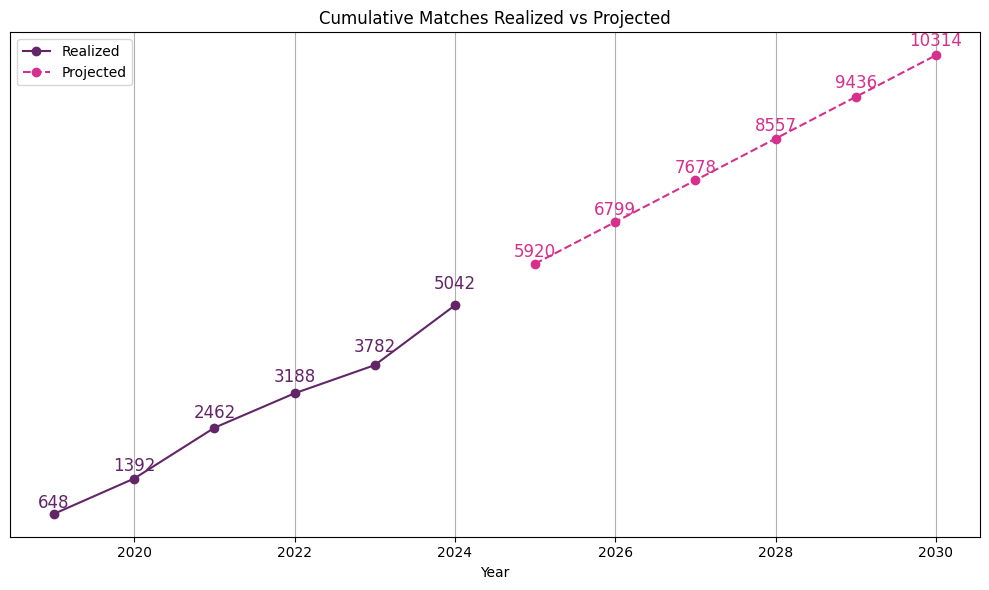

In [20]:
# separate the data
realized = projection_df[projection_df['data'] == 'realized']
projected = projection_df[projection_df['data'] == 'projected']

plt.figure(figsize=(10, 6))
plt.plot(realized.index, realized['matches'], label='Realized', color='#622567', marker='o')
plt.plot(projected.index, projected['matches'], label='Projected', color='#D62F8C', linestyle='--', marker='o')

# add the values on top of each point
for i, v in realized['matches'].items():
    plt.text(i, v * 1.05, str(v), ha='center', va='bottom', fontsize=12, color='#622567')

for i, v in projected['matches'].items():
    plt.text(i, v * 1.01, str(v), ha='center', va='bottom', fontsize=12, color='#D62F8C')


plt.title('Cumulative Matches Realized vs Projected')
plt.xlabel('Year')
# plt.ylabel('Number of Matches')
plt.ylabel('')  # removes the title from the Y axis
plt.yticks([])  # removes the values from the Y axis
plt.legend()
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


Graph with actual matches up to 2024 and projected matches from 2025-2030, based on the average growth observed between 2019 and 2024.

It can be said that it is possible to double the total number of matches by 2030, reaching the target of 10,000.

Constraints:
- Growth and availability of volunteers.
- It was not possible to know the growth rate of volunteers because there is no information on their start date.

## Dataviz

### full_matches

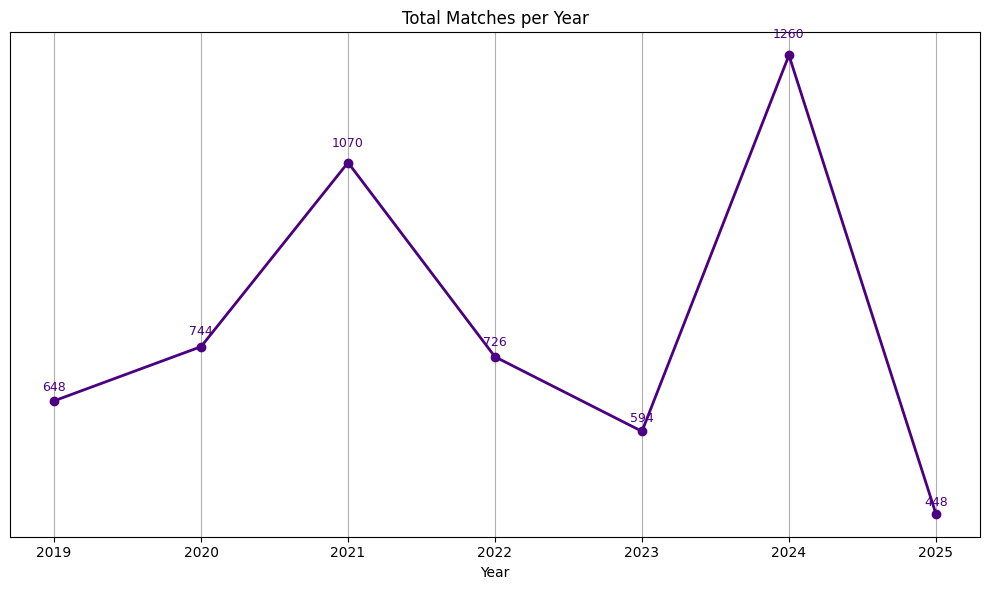

In [21]:
# grouped
matches_per_year = df_.groupby('year').size()

plt.figure(figsize=(10, 6))
plt.plot(matches_per_year.index, matches_per_year.values, marker='o', color='#4B0082', linewidth=2)

# adds the values above each point
for year, value in matches_per_year.items():
    plt.text(year, value * 1.02, str(value), ha='center', va='bottom', fontsize=9, color='#4B0082')

plt.title('Total Matches per Year')
plt.xlabel('Year')
plt.ylabel('')
plt.yticks([])
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


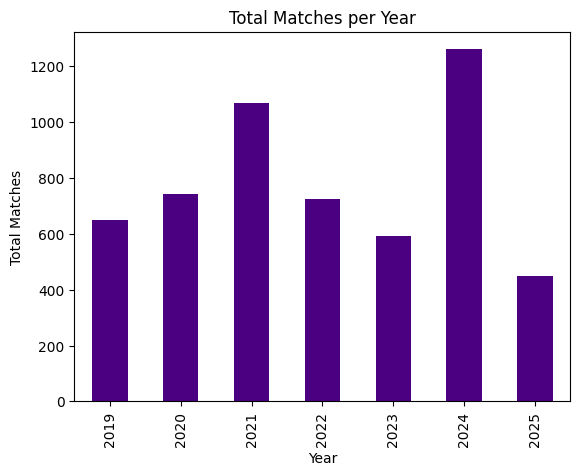

In [22]:
df_.groupby('year').size().plot(kind='bar', color='#4B0082');

plt.title('Total Matches per Year')
plt.xlabel('Year')
plt.ylabel('Total Matches');

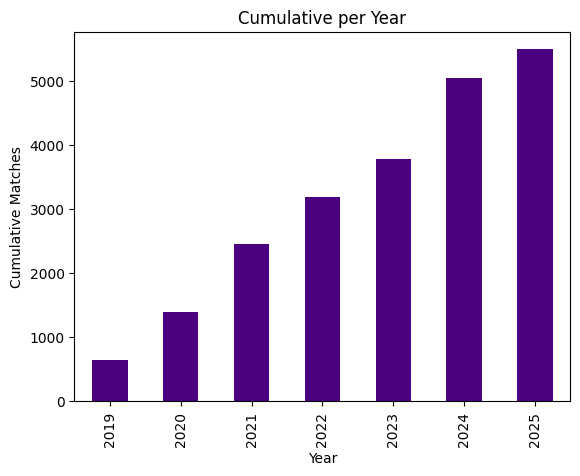

In [23]:
df_.groupby('year').size().cumsum().plot(kind='bar', color='#4B0082');

plt.title('Cumulative per Year')
plt.xlabel('Year')
plt.ylabel('Cumulative Matches');

In [24]:
# df_filtrado = df_[df_['year'].dt.year <= 2024]

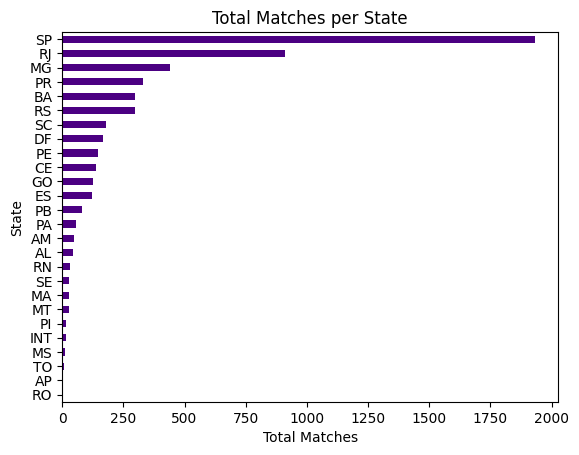

In [25]:
df_.groupby('msr_state').size().sort_values(ascending=True).plot(kind='barh', color='#4B0082');

plt.title('Total Matches per State')
plt.ylabel('State')
plt.xlabel('Total Matches');

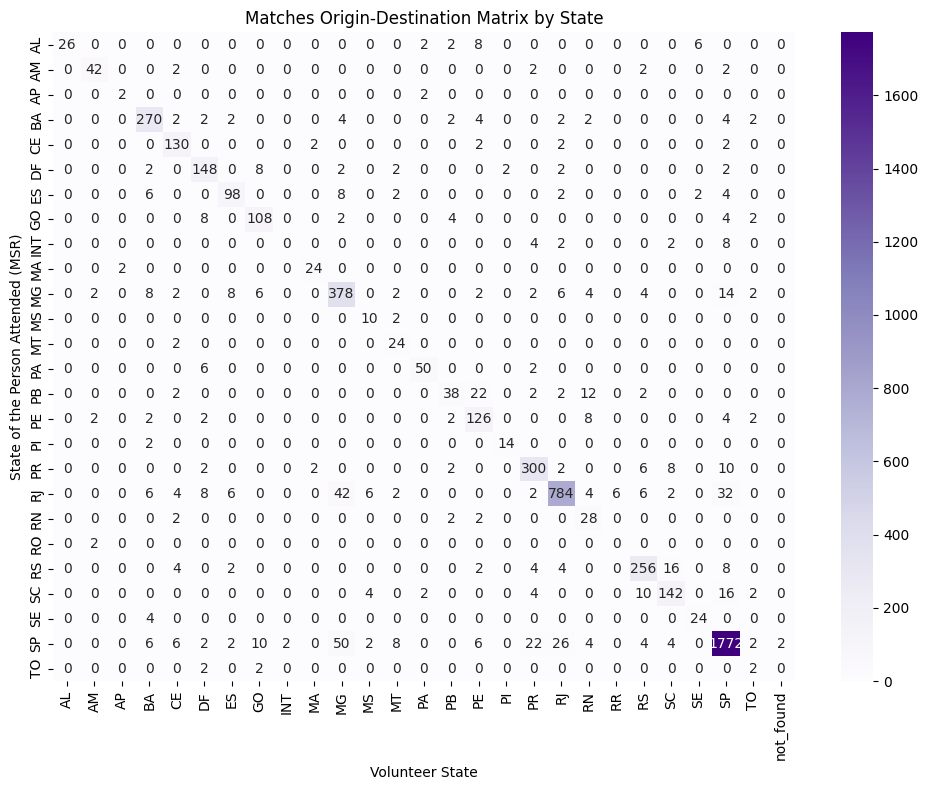

In [26]:
# how many matches per state-origin x state-destination combination
heatmap_data = df_.groupby(['msr_state', 'volunteer_state']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='Purples')

plt.title('Matches Origin-Destination Matrix by State')
plt.xlabel('Volunteer State')
plt.ylabel('State of the Person Attended (MSR)')
plt.tight_layout()
plt.show()


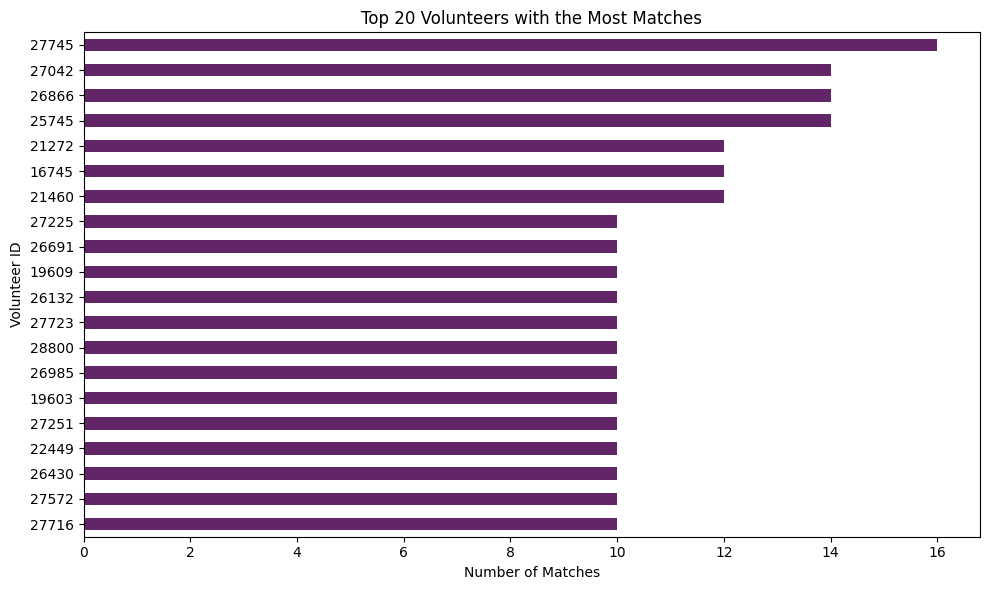

In [27]:
# top 20 volunteers with the most matches
volunteer_counts = df_['volunteer_id'].value_counts().head(20)

volunteer_counts.plot(kind='barh', figsize=(10, 6), color='#622567')
plt.title('Top 20 Volunteers with the Most Matches')
plt.xlabel('Number of Matches')
plt.ylabel('Volunteer ID')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### volunteers

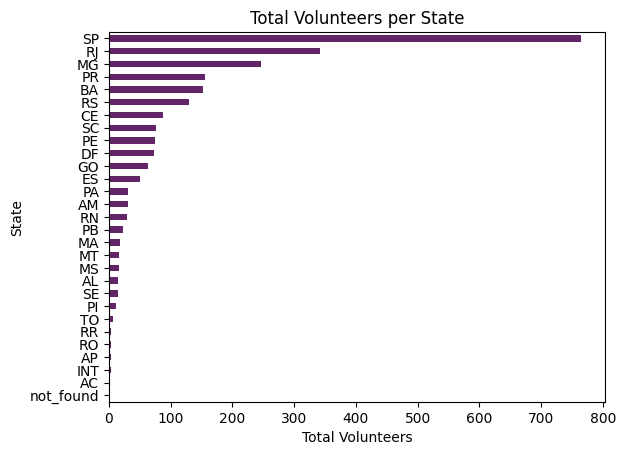

In [28]:
df_volunteers_.groupby('state').size().sort_values(ascending=True).plot(kind='barh', color='#622567');

plt.title('Total Volunteers per State')
plt.ylabel('State')
plt.xlabel('Total Volunteers');

In [29]:
df_volunteers_.head()

,volunteer_id,status,city,state
0,26483,indisponivel,SAO PAULO,SP
1,24077,indisponivel,BRASILIA,DF
2,20555,indisponivel,RIO DE JANEIRO,RJ
3,25612,indisponivel,RIO DE JANEIRO,RJ
4,19619,indisponivel,CAUCAIA,CE


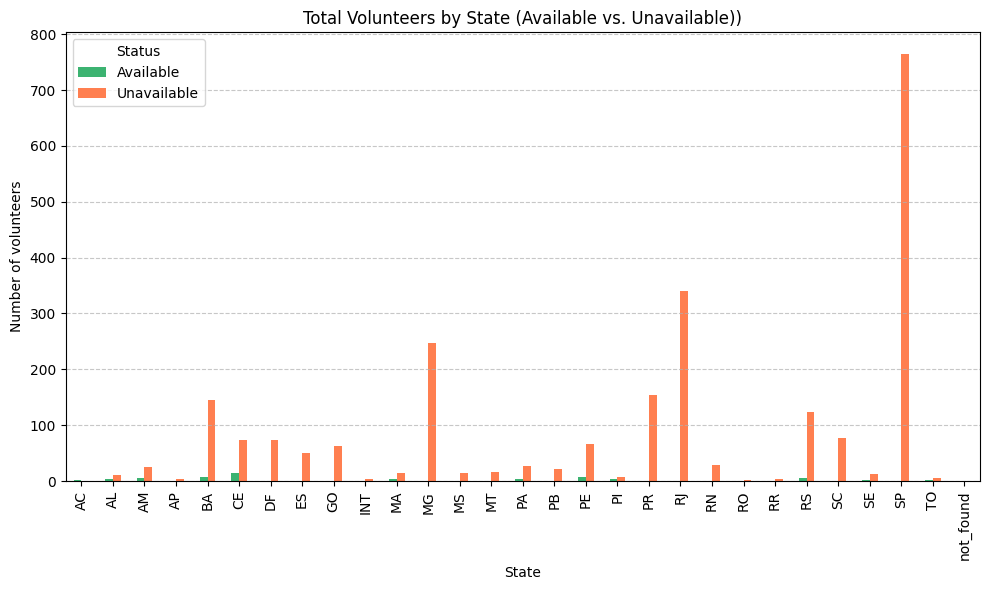

In [30]:
df_volunteers_['status'] = df_volunteers_['status'].replace({
    'disponivel': 'Available',
    'indisponivel': 'Unavailable'
})

grouped = df_volunteers_.groupby(['state', 'status']).size().unstack(fill_value=0)

grouped.plot(kind='bar', stacked=False, figsize=(10, 6), color=['#3CB371', '#FF7F50'])

plt.title('Total Volunteers by State (Available vs. Unavailable))')
plt.xlabel('State')
plt.ylabel('Number of volunteers')
plt.legend(title='Status')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

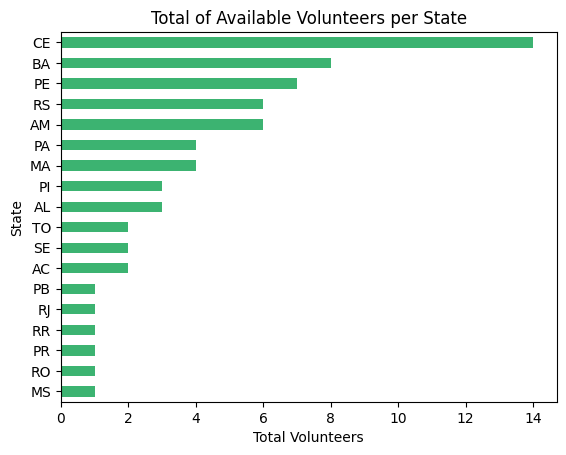

In [31]:
df_volunteers_.query('status == "Available"').groupby('state').size().sort_values(ascending=True).plot(kind='barh', color='#3CB371');

plt.title('Total of Available Volunteers per State')
plt.ylabel('State')
plt.xlabel('Total Volunteers');